In [120]:
# Data set has to be downloaded before running this script!
# On this notebbok the dataset is located in the root derectory as a refernce to another google drive.
# Dataset will also be provided per team:
# - Dataset should be of size 2.1 GB or more - "fmak_wav-20251212T081948Z-3-002" or "FMAK_data"
from google.colab import drive
import os
import pandas as pd
import numpy as np

from glob import glob
import subprocess
import soundfile as sf

import librosa
from tqdm import tqdm

!pip install imbalanced-learn

In [121]:
!ls /content/drive/MyDrive/Colab\ Notebooks/Random\ Forest\ Model\ -\ ML\ Final

 audio_features_with_labels.csv
 audio_features_with_labels_plus_tonnetz_cqt.csv
 available_balanced.csv
 fmak_wav
'Random Forest Model - ML Final.ipynb'
 rf_key_classifier.joblib


In [122]:
# Step 1: Open the dataset
from google.colab import drive
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final"


AVAILABLE_CSV = os.path.join(DRIVE_ROOT, "available_balanced.csv")

#wav_files = os.path.join(DRIVE_ROOT,"fmak_wav")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
df = pd.read_csv(AVAILABLE_CSV)
df.head()

,track_id,audio_path,key_label
0,20013,fmak_wav/020/020013.wav,A minor
1,20033,fmak_wav/020/020033.wav,G# Major
2,20044,fmak_wav/020/020044.wav,F Major
3,20052,fmak_wav/020/020052.wav,D Major
4,20053,fmak_wav/020/020053.wav,C minor


In [124]:
# Step 2: Encode the key labels

# encoding keys as integers
tonics = ["C","C#/Db","D","D#/Eb","E","F","F#Gb","G","G#/Ab","A", "A#/Bb", "B"]
modes = ["major", "minor"]

Mkey_labels = {}  #Hashmap or Dictionary

index = 0
for mode in modes:
  for key in tonics:
    Mkey_labels[key+" "+mode] = index
    index += 1

In [125]:
'''
Encoding global key values in dataframe into integers, based on the Mkey_labels dictionary
The model is intended to use a label such as "C#Db" when classifying an enharmonic key.
However, the dataset only lists one of the two keys in the enharmonics pair; this needs to be accounted for
'''

# Creating a normalization dictionary
canon = {
    "C":"C",
    "C#":"C#/Db",
    "Db": "C#/Db",
    "D": "D",
    "D#": "D#/Eb",
    "Eb#": "D#/Eb",
    "E": "E",
    "F": "F",
    "F#": "F#Gb",
    "Gb": "Gb",
    "G": "G",
    "G#": "G#/Ab",
    "Ab": "G#/Ab",
    "A": "A",
    "A#": "A#/Bb",
    "Bb": "A#/Bb",
    "B": "B"
}

In [126]:
'''
(normalization) converting keys to cannonical labels
Example, if key = Bb major, then normalize_key ("Bb major") will
convert "Bb" to "A#/Bb" and return "A#/Bb major"
'''

def normalize_key(s):
  tonic, mode = s.split()
  tonic = canon[tonic]
  mode = mode.lower()
  return f"{tonic} {mode}"

df["norm_key_label"] = df["key_label"].apply(normalize_key)
df["norm_key_int"] = df["norm_key_label"].map(Mkey_labels)
print(df)

           track_id                      audio_path key_label norm_key_label  \
0             20013         fmak_wav/020/020013.wav   A minor        A minor   
1             20033         fmak_wav/020/020033.wav  G# Major    G#/Ab major   
2             20044         fmak_wav/020/020044.wav   F Major        F major   
3             20052         fmak_wav/020/020052.wav   D Major        D major   
4             20053         fmak_wav/020/020053.wav   C minor        C minor   
...             ...                             ...       ...            ...   
3135   37627_ps_dn1   fmak_wav_aug/37627_ps_dn1.wav  C# Major    C#/Db major   
3136  37627_ts_fast  fmak_wav_aug/37627_ts_fast.wav  C# Major    C#/Db major   
3137  37627_ts_slow  fmak_wav_aug/37627_ts_slow.wav  C# Major    C#/Db major   
3138   39393_ps_up2   fmak_wav_aug/39393_ps_up2.wav  C# Major    C#/Db major   
3139   39393_ps_dn2   fmak_wav_aug/39393_ps_dn2.wav  C# Major    C#/Db major   

      norm_key_int  
0               21

In [127]:
# Step 3: Check for missing files
missing = []

total_count = 0
for i, row in df.iterrows():
  path = os.path.join(DRIVE_ROOT, row["audio_path"])
  if not os.path.exists(path):
    missing.append(path)
  total_count += 1
print("Missing count:", len(missing), "out of", total_count)
missing[:10]

Missing count: 487 out of 3140


['/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ps_up2.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ps_dn2.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ps_up1.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ps_dn1.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ts_fast.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/25637_ts_slow.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/29611_ps_up2.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/29611_ps_dn2.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/fmak_wav_aug/29611_ps_up1.wav',
 '/content/drive/MyDrive/Colab Notebooks/Random Forest Model -

In [128]:
#dropping rows with missing files
df = df[~df["audio_path"].str.contains("fmak_wav_aug")]
df = df.reset_index(drop=True)
print(len(df), "available")

2653 available


In [129]:
!ls /content/drive/MyDrive/Colab\ Notebooks/Random\ Forest\ Model\ -\ ML\ Final/fmak_wav

020  025  030  035  040  045  080  085	100  105  110  115  120
021  026  031  036  041  046  081  086	101  106  111  116  121
022  027  032  037  042  047  082  087	102  107  112  117  122
023  028  033  038  043  048  083  088	103  108  113  118  123
024  029  034  039  044  049  084  089	104  109  114  119  124


In [130]:
# ==== STEP 4: FEATURE EXTRACTION WITH LIBROSA ====

def extract_features(file_path, sr=22050):
    """
    Extracts a set of summary features from an audio file using librosa.
    All features are numeric so they work nicely with RandomForest.
    """
    # load audio; mono=True collapses to mono, which is fine for key detection
    y, sr = librosa.load(file_path, sr=sr, mono=True)

    # Safety check: if file is empty or super short
    if len(y) == 0:
        # Return zeros for everything so code doesn't crash
        return {

        }

    # --- Time–frequency features ---
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    # --- MFCCs (classic for audio tasks) ---
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    features = {
        "chroma_stft_mean": np.mean(chroma_stft),
        "spectral_centroid_mean": np.mean(spec_centroid),
        "spectral_bandwidth_mean": np.mean(spec_bw),
        "rolloff_mean": np.mean(rolloff),
        "zcr_mean": np.mean(zcr),
    }

    # Add mean of each MFCC coefficient
    for i in range(mfcc.shape[0]):
        features[f"mfcc_{i+1}_mean"] = np.mean(mfcc[i])

    return features


FEATURES_CSV = os.path.join(DRIVE_ROOT, "audio_features_with_labels.csv")

if os.path.exists(FEATURES_CSV):
    print(" Found cached features CSV. Loading:", FEATURES_CSV)
    feat_df = pd.read_csv(FEATURES_CSV)
    print("Loaded saved features:", feat_df.shape)
    feat_df.head()
else:
    print(" Cached features CSV not found. Computing features from audio...")

    feature_rows = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        file_path = os.path.join(DRIVE_ROOT, row["audio_path"])
        feats = extract_features(file_path)

        # If feature extraction failed, skip file
        if not feats:
            continue

        feats["label_int"] = row["norm_key_int"]
        feats["label_str"] = row["norm_key_label"]
        feature_rows.append(feats)

    feat_df = pd.DataFrame(feature_rows)
    print("Feature dataframe shape:", feat_df.shape)

    feat_df.to_csv(FEATURES_CSV, index=False)
    print(" Saved features to:", FEATURES_CSV)



 Found cached features CSV. Loading: /content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/audio_features_with_labels.csv
Loaded saved features: (2653, 29)


In [131]:
'''
OPTIONAL:
if csv alreeady exists you can comment out this feature extraxtion method.

------------------------------------------------------------------
from tqdm import tqdm....
....
# From here on, use combined_df as your working feature dataframe
feat_df = combined_df
------------------------------------------------------------------

Otherwise uncomment this block.

------------------------------------------------------------------

from tqdm import tqdm

def extract_new_features(file_path, sr=22050):
    """
    Compute ONLY Tonnetz + Chroma CQT features.
    We do NOT recompute MFCC/spectral because we already have them saved.
    """
    y, sr = librosa.load(file_path, sr=sr, mono=True, duration=25)

    if len(y) == 0:
        return {
            "tonnetz_1_mean": np.nan,
            "tonnetz_2_mean": np.nan,
            "tonnetz_3_mean": np.nan,
            "tonnetz_4_mean": np.nan,
            "tonnetz_5_mean": np.nan,
            "tonnetz_6_mean": np.nan,
            "chroma_cqt_mean": np.nan,
            "chroma_cqt_std": np.nan,
        }

    feats = {}

    # Tonnetz
    try:
        ton = librosa.feature.tonnetz(y=y, sr=sr)
        ton_means = ton.mean(axis=1)
        for i in range(6):
            feats[f"tonnetz_{i+1}_mean"] = ton_means[i]
    except:
        for i in range(6):
            feats[f"tonnetz_{i+1}_mean"] = np.nan

    # Chroma CQT
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    feats["chroma_cqt_mean"] = float(np.mean(chroma_cqt))
    feats["chroma_cqt_std"] = float(np.std(chroma_cqt))

    return feats



# Compute ONLY the new features (tonnetz + chroma_cqt) for each file
new_feature_rows = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(DRIVE_ROOT, row["audio_path"])
    new_feats = extract_new_features(file_path)
    new_feature_rows.append(new_feats)

#new_feats_df = pd.DataFrame(new_feature_rows)
print("New features shape:", new_feats_df.shape)
print(new_feats_df.head())

# Sanity check: row counts should match
print("Original feat_df rows:", feat_df.shape[0])
print("New feats rows:", new_feats_df.shape[0])

# Combine old + new features side by side
combined_df = pd.concat([feat_df, new_feats_df], axis=1)
print("Combined features shape:", combined_df.shape)
combined_df.head()

# Save to a NEW CSV so you keep the original too
UPDATED_FEATURES_CSV = os.path.join(
    DRIVE_ROOT, "audio_features_with_labels_plus_tonnetz_cqt.csv"
)
combined_df.to_csv(UPDATED_FEATURES_CSV, index=False)

print("Saved updated features to:", UPDATED_FEATURES_CSV)

# From here on, use combined_df as your working feature dataframe
feat_df = combined_df

'''


'\nOPTIONAL:\nif csv alreeady exists you can comment out this feature extraxtion method.\n\n------------------------------------------------------------------\nfrom tqdm import tqdm....\n....\n# From here on, use combined_df as your working feature dataframe\nfeat_df = combined_df\n------------------------------------------------------------------\n\nOtherwise uncomment this block.\n\n------------------------------------------------------------------\n\nfrom tqdm import tqdm\n\ndef extract_new_features(file_path, sr=22050):\n    """\n    Compute ONLY Tonnetz + Chroma CQT features.\n    We do NOT recompute MFCC/spectral because we already have them saved.\n    """\n    y, sr = librosa.load(file_path, sr=sr, mono=True, duration=25)\n\n    if len(y) == 0:\n        return {\n            "tonnetz_1_mean": np.nan,\n            "tonnetz_2_mean": np.nan,\n            "tonnetz_3_mean": np.nan,\n            "tonnetz_4_mean": np.nan,\n            "tonnetz_5_mean": np.nan,\n            "tonnetz_6_

In [132]:
feat_df["binary_label"] = feat_df["label_str"].apply(
    lambda x: "major" if "major" in x else "minor"
)

In [133]:
# === LOAD PREVIOUSLY SAVED FEATURES INSTEAD OF RECOMPUTING ===

FEATURES_CSV = os.path.join(DRIVE_ROOT, "audio_features_with_labels_plus_tonnetz_cqt.csv")
feat_df = pd.read_csv(FEATURES_CSV)

print("Loaded features:", feat_df.shape)
print(feat_df.head())


Loaded features: (2653, 29)
   chroma_stft_mean  spectral_centroid_mean  spectral_bandwidth_mean  \
0          0.193182              927.324794              1037.456862   
1          0.290648             1218.551340              1029.583504   
2          0.312583             1542.159242               947.094370   
3          0.302026             2140.650512              2390.452253   
4          0.377191             2282.209211              2275.212795   

   rolloff_mean  zcr_mean  mfcc_1_mean  mfcc_2_mean  mfcc_3_mean  mfcc_4_mean  \
0   1879.192936  0.041835  -369.806520   151.090530   -32.866142    15.762250   
1   2238.127720  0.078018  -318.950960   184.796140   -72.511130    -2.846012   
2   2656.257362  0.132403  -310.163850   197.741620  -116.262314   -15.371613   
3   4463.778455  0.094187  -104.646324    97.025055    -5.738223     6.657701   
4   4549.253667  0.113110   -28.240097    95.181880   -27.143726    11.511613   

   mfcc_5_mean  ...    label_str  binary_label  tonn

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Drop any rows with NaNs from the new features (just in case)
feat_df = feat_df.dropna().reset_index(drop=True)

# Separate features and labels
X = feat_df.drop(columns=["label_int", "label_str", "binary_label"])
y = feat_df["binary_label"]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/validation split (same as before)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class counts in y_train (before oversampling):")
print(y_train.value_counts().sort_index())

# ==== OVERSAMPLING ON TRAIN ONLY ====
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("\nClass counts in y_train_res (after oversampling):")
print(y_train_res.value_counts().sort_index())

# Random Forest model
rf_balanced = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features = "sqrt",
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train_res, y_train_res)

# Evaluation on validation set (unchanged, still imbalanced & realistic)
y_val_pred = rf_balanced.predict(X_val)

print("\nClassification Report (validation, after oversampling):")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("Confusion matrix (validation, after oversampling, with tonnetz + cqt):")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)


X shape: (2653, 26)
y shape: (2653,)
Class counts in y_train (before oversampling):
binary_label
major    1118
minor    1004
Name: count, dtype: int64

Class counts in y_train_res (after oversampling):
binary_label
major    1118
minor    1118
Name: count, dtype: int64

Classification Report (validation, after oversampling):
              precision    recall  f1-score   support

       major       0.63      0.67      0.65       280
       minor       0.60      0.56      0.58       251

    accuracy                           0.62       531
   macro avg       0.62      0.61      0.61       531
weighted avg       0.62      0.62      0.62       531

Confusion matrix (validation, after oversampling, with tonnetz + cqt):
[[188  92]
 [111 140]]


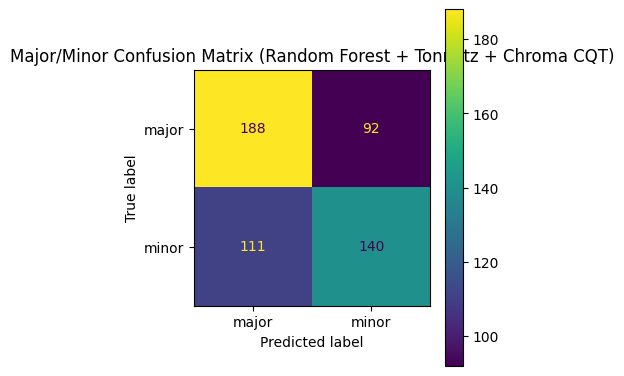

In [135]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_balanced.classes_)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, values_format="d")
plt.title("Major/Minor Confusion Matrix (Random Forest + Tonnetz + Chroma CQT)")
plt.tight_layout()
plt.show()


In [136]:
import joblib
MODEL_PATH = os.path.join(DRIVE_ROOT, "rf_key_classifier.joblib")
FEATURES_CSV = os.path.join(DRIVE_ROOT, "audio_features_with_labels.csv")

joblib.dump(rf_balanced, MODEL_PATH)
feat_df.to_csv(FEATURES_CSV, index=False)

print("Saved model to:", MODEL_PATH)
print("Saved features to:", FEATURES_CSV)

Saved model to: /content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/rf_key_classifier.joblib
Saved features to: /content/drive/MyDrive/Colab Notebooks/Random Forest Model - ML Final/audio_features_with_labels.csv
